IMPORTING LIBRARIES

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import scipy

In [2]:
from matplotlib import pyplot as plt

In [6]:
data = pd.read_csv('creditcard.csv')
print(data.columns)

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


In [8]:
data = data.sample(frac=0.1,random_state=1)
print(data.shape)
print(data.describe())

(28481, 31)
                Time            V1            V2            V3            V4  \
count   28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean    94705.035216     -0.001143     -0.018290      0.000795      0.000350   
std     47584.727034      1.994661      1.709050      1.522313      1.420003   
min         0.000000    -40.470142    -63.344698    -31.813586     -5.266509   
25%     53924.000000     -0.908809     -0.610322     -0.892884     -0.847370   
50%     84551.000000      0.031139      0.051775      0.178943     -0.017692   
75%    139392.000000      1.320048      0.792685      1.035197      0.737312   
max    172784.000000      2.411499     17.418649      4.069865     16.715537   

                 V5            V6            V7            V8            V9  \
count  28481.000000  28481.000000  28481.000000  28481.000000  28481.000000   
mean      -0.015666      0.003634     -0.008523     -0.003040      0.014536   
std        1.395552      1.334

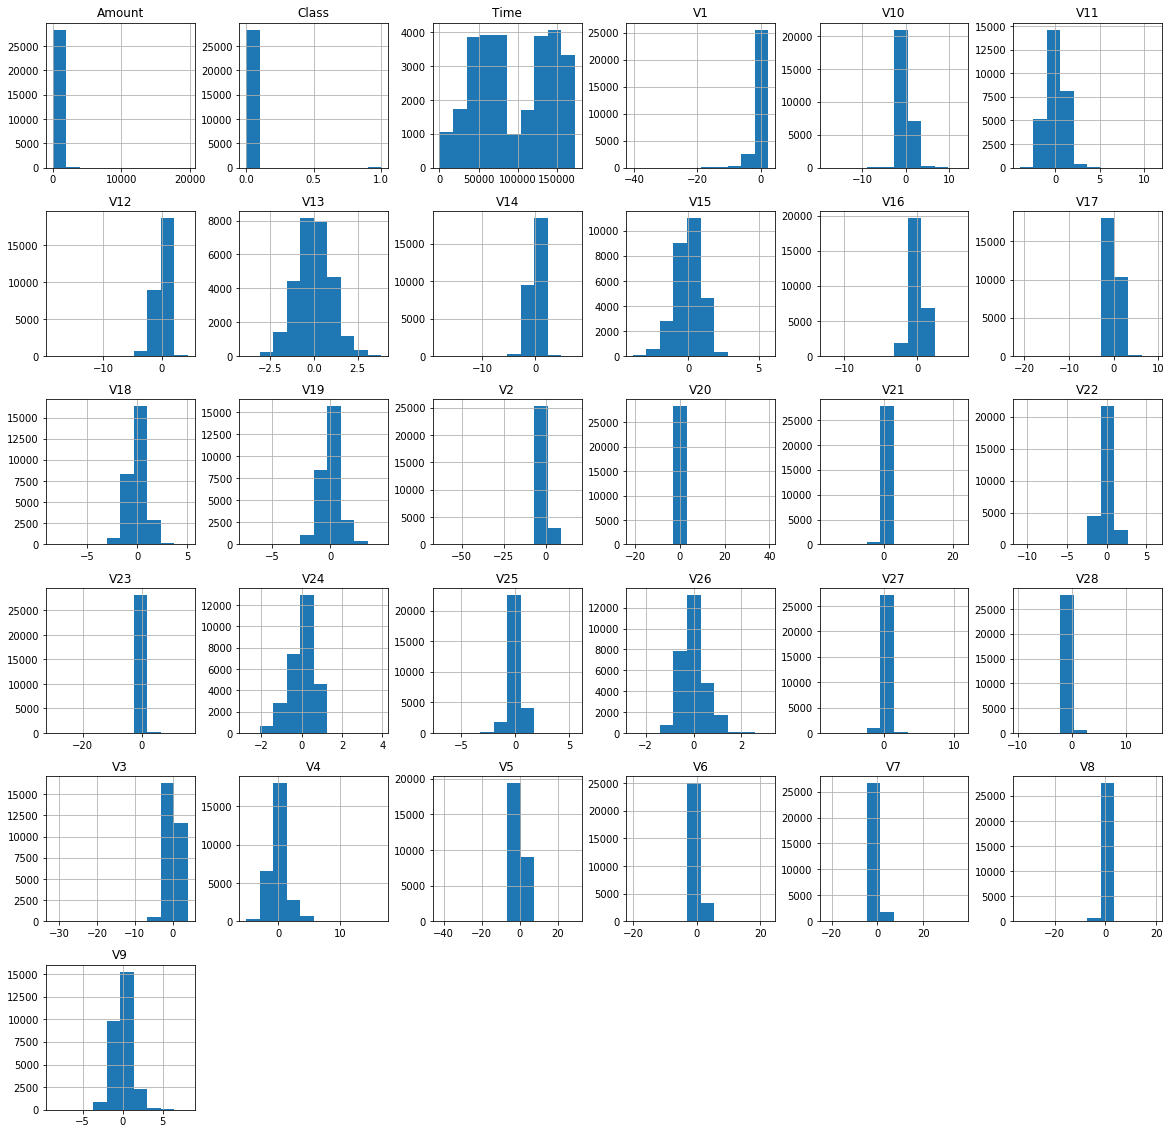

In [9]:
data.hist(figsize = (20,20))
plt.show()

In [11]:
Fraud = data[data['Class'] == 1]
Valid = data[data['Class'] == 0]
outlier_fraction = len(Fraud)/float(len(Valid))
print(outlier_fraction)
print('Fraud Cases: {}'.format(len(data[data['Class'] == 1])))
print('Valid Transactions: {}'.format(len(data[data['Class'] == 0])))

0.0017234102419808666
Fraud Cases: 49
Valid Transactions: 28432


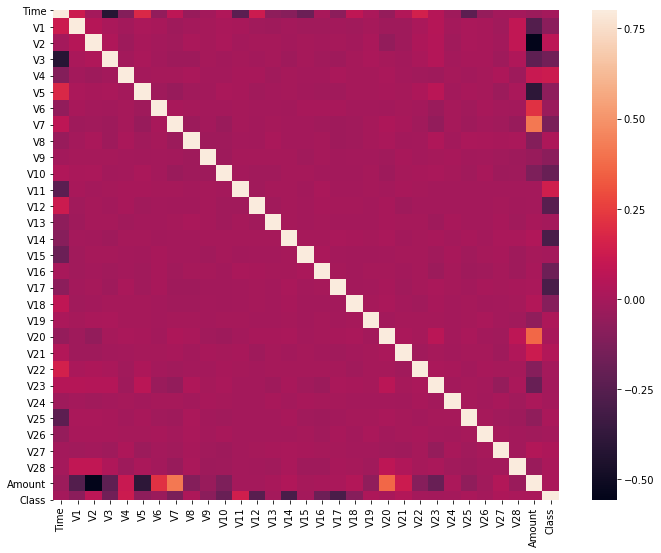

In [12]:
corrmat = data.corr()
fig = plt.figure(figsize = (12,9))
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

In [13]:
# Get all the columns from the dataFrame
columns = data.columns.tolist()

# Filter the columns to remove data we do not want
columns = [c for c in columns if c not in ["Class"]]

In [15]:
target = "Class"
X = data[columns]
Y = data[target]

# Print shapes
print(X.shape)
print(Y.shape)

(28481, 30)
(28481,)


Unsupervised Outlier Detection
LOF : The anomoly score of each sample is LOF. It measures the local deviation of density of a given sample with respect to its neighbors. The anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.

Isolation Forest Algorithm
The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.
Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.
This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.
Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [16]:
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [18]:
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(X),
                                        contamination=outlier_fraction,
                                        random_state=6),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)}

In [19]:
# Fit the model
plt.figure(figsize=(9, 7))
n_outliers = len(Fraud)

<Figure size 648x504 with 0 Axes>

In [20]:
for i, (clf_name, clf) in enumerate(classifiers.items()):
    
    # fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_pred = clf.negative_outlier_factor_
    else:
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        y_pred = clf.predict(X)
    
    # Reshape the prediction values to 0 for valid, 1 for fraud. 
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    
    n_errors = (y_pred != Y).sum()
    
    # Run classification metrics
    print('{}: {}'.format(clf_name, n_errors))
    print(accuracy_score(Y, y_pred))
    print(classification_report(Y, y_pred))

C:\ProgramData\Anaconda3\new\lib\site-packages\sklearn\ensemble\iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\ProgramData\Anaconda3\new\lib\site-packages\sklearn\ensemble\iforest.py:415: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


Isolation Forest: 77
0.9972964432428637
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.22      0.22      0.22        49

    accuracy                           1.00     28481
   macro avg       0.61      0.61      0.61     28481
weighted avg       1.00      1.00      1.00     28481

Local Outlier Factor: 97
0.9965942207085425
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     28432
           1       0.02      0.02      0.02        49

    accuracy                           1.00     28481
   macro avg       0.51      0.51      0.51     28481
weighted avg       1.00      1.00      1.00     28481

